## Setup Github

Import the github repository and move it into the local directory (also remove the defult samples directoy if it exists)

In [1]:
from getpass import getpass
import os

user = "Boyne272"
password = getpass('github password')
os.environ['GITHUB_AUTH'] = user + ':' + password

# clone the repo
!git clone https://$GITHUB_AUTH@github.com/msc-acse/acse-8-miniproject-softmax.git repo
    
# move the repo up one
!mv repo/* .
!mv repo/.git .

# delete un needed stuff
!rm -r repo
!rm -r sample_data/

github password··········
Cloning into 'repo'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 266 (delta 38), reused 46 (delta 21), pack-reused 195
Receiving objects: 100% (266/266), 31.15 MiB | 27.35 MiB/s, done.
Resolving deltas: 100% (139/139), done.


### Github Commands

In [2]:
# !git checkout richard
# !git reset --hard
# !git pull origin richard
!ls -l
!git log

total 32
drwxr-xr-x 2 root root 4096 May 21 13:44 data
drwxr-xr-x 2 root root 4096 May 21 13:44 models
-rw-r--r-- 1 root root  771 May 21 13:44 README.md
drwxr-xr-x 2 root root 4096 May 21 13:44 spec
-rw-r--r-- 1 root root 8812 May 21 13:44 tools.py
drwxr-xr-x 3 root root 4096 May 21 13:44 training
commit 591e1df8f3f4604084af0cbda0a66fb5faf82074 (HEAD -> master, origin/master, origin/HEAD)
Merge: 450e672 e41b7b3
Author: mattia <mattguerri1@gmail.com>
Date:   Tue May 21 14:40:19 2019 +0100

    Merge pull request #10 from msc-acse/mattia
    
    Mattia

commit e41b7b30e83ba000b7ec52f86b2743f41d3cea2f (origin/mattia)
Author: mattiaguerri <mattguerri1@gmail.com>
Date:   Tue May 21 14:38:33 2019 +0100

    AlexNet DropOut

commit 53ce963e7ff3983eb118a70b7f44b110b55bffdb
Merge: 017c440 450e672
Author: mattiaguerri <mattguerri1@gmail.com>
Date:   Tue May 21 14:24:05 2019 +0100

    Merge branch 'master' into mattia
    
    fix tool

commit 450e672e6c1b8eccf355552150bee2564cbfe96a (origin/u

## Setup Imports

Ipython imports and functions

In [3]:
# ipython setup
!pip install pycm livelossplot
%pylab inline
%load_ext autoreload
%autoreload 2

     |████████████████████████████████| 51kB 1.7MB/s 
     |████████████████████████████████| 491kB 9.6MB/s 
     |████████████████████████████████| 215kB 55.5MB/s 
ERROR: datascience 0.10.6 has requirement coverage==3.7.1, but you'll have coverage 4.5.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: coveralls 0.5 has requirement coverage<3.999,>=3.6, but you'll have coverage 4.5.3 which is incompatible.
  Found existing installation: coverage 3.7.1
    Uninstalling coverage-3.7.1:
      Successfully uninstalled coverage-3.7.1
Populating the interactive namespace from numpy and matplotlib


Module imports

In [0]:
# imports
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, RandomCrop, ToPILImage, Pad

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms

# imports from github
from tools import *

Check runtime device

In [5]:
# check running device
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


## Load Data

In [0]:
train_feat = np.load("/content/data/kmnist-train-imgs.npy")
train_targ = np.load("/content/data/kmnist-train-labels.npy")
test_feat = np.load("/content/data/kmnist-test-imgs.npy")

In [7]:
# check what the data looks like
for data, data_name in zip([train_targ, test_feat, train_feat], 
                           ["train_targ", "test_feat", "train_feat"]):
    
    print(data_name)
    
    for name, code in zip(["shape", "mean", "std", "max", "min", "type", "cuda"],
                          ["data.shape", "data.mean()", "data.std()", 
                           "data.max()", "data.min()", "data.dtype"]):
        try:
            exec("print('\t', name, '\t:\t', " + code + ")")
        except:
            print("\t", name, "\t:\t undefined")

train_targ
	 shape 	:	 (60000,)
	 mean 	:	 4.5
	 std 	:	 2.8722813232690143
	 max 	:	 9
	 min 	:	 0
	 type 	:	 uint8
test_feat
	 shape 	:	 (10000, 28, 28)
	 mean 	:	 47.06204145408163
	 std 	:	 87.1110021912918
	 max 	:	 255
	 min 	:	 0
	 type 	:	 uint8
train_feat
	 shape 	:	 (60000, 28, 28)
	 mean 	:	 48.89934757653061
	 std 	:	 88.82742173832395
	 max 	:	 255
	 min 	:	 0
	 type 	:	 uint8


Now set our parameters

In [0]:
# Other Hyperparameters
Seed = 42
Learning_Rate = 1e-2
Momentum = 0.5
Batch_Size = 64
Test_Batch_Size = 1000
Number_of_Epochs = 30

## Data pre-processing

Define the data set creation function with the transformations.

In [0]:
def create_dataset(train, targ, t_id, v_id):
    
    # make trgets torch type and shape
    targ = torch.from_numpy(targ)
    targ = targ.long()
    # (features are changed in the transofrmations)
    
    # seperate the data
    t_feat = train[t_id]
    v_feat = train[v_id]
    t_targ = targ[t_id]
    v_targ = targ[v_id]
    
    # find mean and std
    mean, std = np.mean(t_feat)/255., np.std(t_feat)/255.
    print("avg:", mean, "std:", std)
    
    # includes data augmentation
    train_transform = Compose([
        ToPILImage(),
        RandomCrop(24),
        Pad(2),
        RandomRotation(10),
        ToTensor(),
        Normalize(mean=[mean], std=[std]),
        ])

    # only want to normalize here
    validation_test_transform = Compose([
        ToTensor(),
        Normalize(mean=[mean], std=[std]),
        ])
    
    # create the custom datasets
    train_set = CustomImageTensorDataset(t_feat, t_targ, transform=train_transform)
    valid_set = CustomImageTensorDataset(v_feat, v_targ, transform=validation_test_transform)

    return train_set, valid_set

Create the indicies for the data split

In [16]:
# do the split
n_folds = 10
shuffler =  StratifiedKFold(n_splits=n_folds, random_state=42, shuffle=True)
shuffler = shuffler.split(train_feat, train_targ)

# get the indices
indices = np.array(list(shuffler))
print(indices.shape)
print([i.shape for i in indices.flatten()])

(10, 2)
[(54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,)]


Divide data into n_fold sets

In [17]:
data_loders = []
for t_index, v_index in indices[:2]:
    t_set, v_set = create_dataset(train_feat, train_targ, t_index, v_index)
    data_loders.append([ DataLoader(t_set, batch_size=Batch_Size, shuffle=True),
                         DataLoader(v_set, batch_size=Test_Batch_Size, shuffle=False)])
    
data_loders = np.array(data_loders)
data_loders.shape

avg: 0.19175344221021742 std: 0.34832968140463433
avg: 0.19174826226787012 std: 0.3483234148893105


(2, 2)

Look at the data to check it is all still good

Loaded Feature Shape: torch.Size([64, 1, 28, 28])
Loaded Target Shape: torch.Size([64])
batch mean: tensor(-0.0409)
batch std: tensor(0.9832)


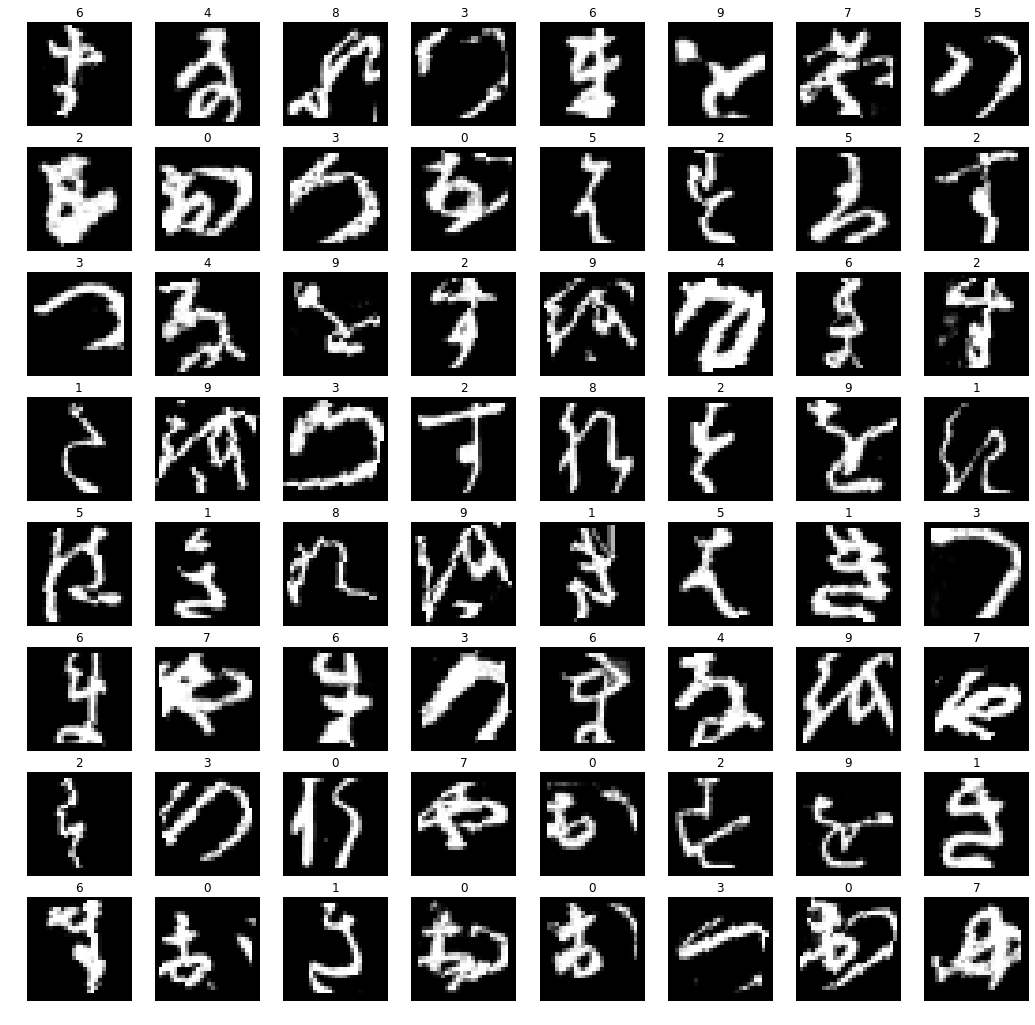

In [18]:
train_loader = data_loders[0, 0]
for X, y in train_loader:
    
    print("Loaded Feature Shape:", X.size())
    print("Loaded Target Shape:", y.size())
    print("batch mean:", X.mean())
    print("batch std:", X.std())
    
    fig, axs = plt.subplots(8, 8, figsize=[18, 18])
    
    for img, lab, ax in zip(X, y, axs.flatten()):
        ax.imshow(img[0], cmap='gray')
        ax.axis("off")
        ax.set(title=str(lab.item()))
    break

What about the standard deviation and mean. Here I manually do the transformation on each sample and look at the transformed data mean, std and shape.

In [13]:
norm = data_loders[0, 1].dataset.transform
manual = [norm(t) for t in train_feat]
manual = torch.stack(manual)
manual.mean(), manual.std(), manual.size()

(tensor(2.1144e-05), tensor(1.0000), torch.Size([60000, 1, 28, 28]))

## Define the Network

In [0]:
# AlexNet_half (sequential)
class AlexNet_half(nn.Module):
    """
    Neural Network inspired on Alexnet, with a reduced number of parameters (989410).
    """

    def __init__(self, bias=True):
        "setup the neural network"
        
        # initalise
        super(AlexNet_half, self).__init__()

        # create the activation function
        act = nn.ReLU()
        
        self.convolutional = nn.Sequential(
            nn.Conv2d(1, 24, padding=1, kernel_size=4, stride=1, bias=bias), act,
            nn.MaxPool2d(kernel_size=1, stride=1), act,
            nn.Conv2d(24, 64, padding=2, kernel_size=5, stride=1, bias=bias), act,
            nn.MaxPool2d(kernel_size=3, stride=2), act,
            nn.Conv2d(64, 96, padding=2, kernel_size=5, stride=1, bias=bias), act,
            nn.Conv2d(96, 96, padding=1, kernel_size=3, stride=1, bias=bias), act,
            nn.Conv2d(96, 64, padding=1, kernel_size=3, stride=1, bias=bias), act,
            nn.MaxPool2d(kernel_size=3, stride=2), act)
        
        self.full_connected = nn.Sequential(
            nn.Linear(2304, 256, bias=bias), act,
            nn.Linear(256, 256, bias=bias), act,
            nn.Linear(256, 10, bias=bias)
        )

    def flatten(self, T):
        "flatten the image for the fully connected layers"
        return T.view(-1, T.size(1)*T.size(2)*T.size(3))
        
        
    def forward(self, x):
        "Pass through the neural network"
        x = self.convolutional(x)
        x = self.flatten(x)
        x = self.full_connected(x)
        return x

## Model Training

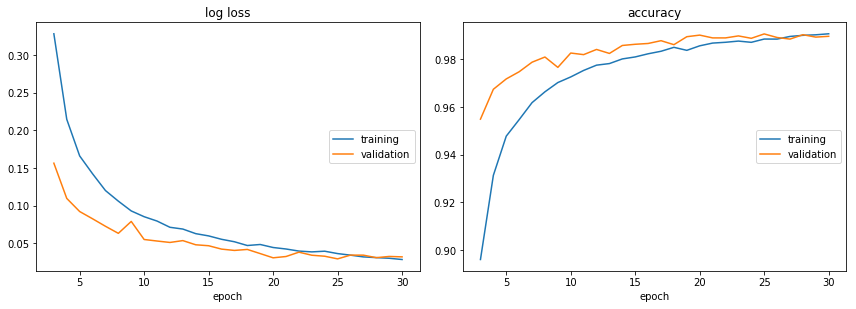

log loss:
training   (min:    0.029, max:    2.161, cur:    0.029)
validation (min:    0.029, max:    1.029, cur:    0.032)

accuracy:
training   (min:    0.202, max:    0.991, cur:    0.991)
validation (min:    0.692, max:    0.991, cur:    0.990)
Training Finished


In [20]:
set_seed(Seed)
model = AlexNet_half().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=Learning_Rate, momentum=Momentum)
criterion = nn.CrossEntropyLoss()
train_loader, validate_loader = data_loders[0]

wrapper = train_wrapper(model, optimizer, train_loader, validate_loader, 
                        criterion=criterion, device=device)
wrapper.train_model(Number_of_Epochs)

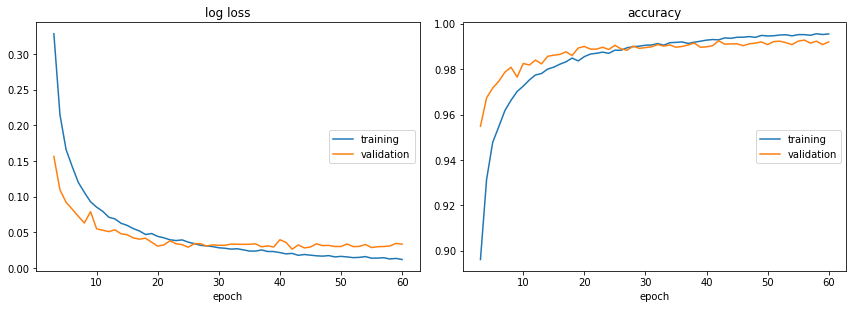

log loss:
training   (min:    0.012, max:    2.161, cur:    0.012)
validation (min:    0.027, max:    1.029, cur:    0.034)

accuracy:
training   (min:    0.202, max:    0.996, cur:    0.996)
validation (min:    0.692, max:    0.993, cur:    0.992)
Training Finished


In [21]:
wrapper.train_model(Number_of_Epochs)

## Save Model

In [22]:
wrapper.save_model("test.pth", path="/")
test = torch.load("/test.pth")
test

saved to /test.pth


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type AlexNet_half. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


{'model': AlexNet_half(
   (convolutional): Sequential(
     (0): Conv2d(1, 24, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
     (3): ReLU()
     (4): Conv2d(24, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
     (5): ReLU()
     (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
     (7): ReLU()
     (8): Conv2d(64, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
     (9): ReLU()
     (10): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (11): ReLU()
     (12): Conv2d(96, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (13): ReLU()
     (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
     (15): ReLU()
   )
   (full_connected): Sequential(
     (0): Linear(in_features=2304, out_features=256, bias=True)
     (1): ReLU()
     (2): Linear(in_features=256, out_features=25

In [23]:
wrapper.max_acc_epoch()

56

Make a prediction

In [24]:
pred = wrapper.evaluate(test_feat, False)
save_csv(pred, "prediction", path="/")

successfully saved in /prediction.csv
